In [1]:
import cv2
import torch
import requests
import numpy as np

from PIL import Image
from io import BytesIO
from transformers import SamModel, SamProcessor, AutoModel

def apply_sam(image, input_points=None, input_boxes=None, input_labels=None):
    inputs = sam_processor(image, input_points=input_points, input_boxes=input_boxes,
                           input_labels=input_labels, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = sam_model(**inputs)

    masks = sam_processor.image_processor.post_process_masks(
        outputs.pred_masks.cpu(),
        inputs["original_sizes"].cpu(),
        inputs["reshaped_input_sizes"].cpu()
    )[0][0]
    scores = outputs.iou_scores[0, 0]

    mask_selection_index = scores.argmax()
    mask_np = masks[mask_selection_index].numpy()
    return mask_np


def add_contour(img, mask, input_points=None, input_boxes=None):
    img = img.copy()
    mask = mask.astype(np.uint8) * 255
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, (1.0, 1.0, 1.0), thickness=6)

    if input_points is not None:
        for points in input_points:
            for x, y in points:
                cv2.circle(img, (int(x), int(y)), radius=10, color=(1.0, 0.0, 0.0), thickness=-1)
                cv2.circle(img, (int(x), int(y)), radius=10, color=(1.0, 1.0, 1.0), thickness=2)

    if input_boxes is not None:
        for box_batch in input_boxes:
            for box in box_batch:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(1.0, 1.0, 1.0), thickness=4)
                cv2.rectangle(img, (x1, y1), (x2, y2), color=(1.0, 0.0, 0.0), thickness=2)

    return img

def print_streaming(text):
    print(text, end="", flush=True)

In [3]:
CACHE_DIR = "./cache"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sam_model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
sam_processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

model = AutoModel.from_pretrained('nvidia/DAM-3B-Self-Contained', trust_remote_code=True, torch_dtype='torch.float16', cache_dir=CACHE_DIR).to(device)
dam = model.init_dam(conv_mode='v1', prompt_mode='full+focal_crop')

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

Fetching 21 files:   0%|          | 0/21 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Number of mask channels: 1


In [5]:
# Download the image via HTTP
image_url = 'https://github.com/NVlabs/describe-anything/blob/main/images/1.jpg?raw=true'
response = requests.get(image_url)
img = Image.open(BytesIO(response.content)).convert('RGB')
image_size = img.size

# Define two runs: one with points, one with box
runs = [
    {
        'use_box': False,
        'points': [[1172, 812], [1572, 800]],
        'output_image_path': 'output_visualization_points.png'
    },
    {
        'use_box': True,
        'box': [800, 500, 1800, 1000],
        'output_image_path': 'output_visualization_box.png'
    }
]

for run in runs:
    if run['use_box']:
        # Prepare box input
        coords = run['box']
        input_boxes = [[coords]]
        print(f"Running inference with input_boxes: {input_boxes}")
        mask_np = apply_sam(img, input_boxes=input_boxes)
        vis_points = None
        vis_boxes = input_boxes
    else:
        # Prepare point input
        pts = run['points']
        input_points = [pts]
        input_labels = [[1] * len(pts)]
        print(f"Running inference with input_points: {input_points}")
        mask_np = apply_sam(img, input_points=input_points, input_labels=input_labels)
        vis_points = input_points
        vis_boxes = None

    # Convert mask and describe
    mask = Image.fromarray((mask_np * 255).astype(np.uint8))
    print("Description:")
    for token in dam.get_description(
        img,
        mask,
        '<image>\nDescribe the masked region in detail.',
        streaming=True,
        temperature=0.2,
        top_p=0.5,
        num_beams=1,
        max_new_tokens=512
    ):
        print_streaming(token)
    print()  # newline

    # Save visualization with contour
    img_np = np.asarray(img).astype(float) / 255.0
    img_with_contour_np = add_contour(img_np, mask_np,
                                        input_points=vis_points,
                                        input_boxes=vis_boxes)
    img_with_contour_pil = Image.fromarray((img_with_contour_np * 255.0).astype(np.uint8))
    img_with_contour_pil.save(run['output_image_path'])
    print(f"Output image with contour saved as {run['output_image_path']}")


Running inference with input_points: [[[1172, 812], [1572, 800]]]
Description:
A medium-sized dog with a thick, reddish-brown coat and white markings on its face, chest, and paws. The dog has pointed ears, a bushy tail, and is wearing a red collar. Its mouth is open, showing its tongue and teeth, and it appears to be in mid-leap.
Output image with contour saved as output_visualization_points.png
Running inference with input_boxes: [[[800, 500, 1800, 1000]]]
Description:
A medium-sized, tan and white dog with a thick, fluffy coat. The dog has a broad head with erect, pointed ears and a black nose. Its eyes are dark and alert. The dog is wearing a red collar with a silver tag. Its mouth is open, revealing its tongue and teeth, and its front legs are extended forward, with white paws. The dog's body is muscular and well-proportioned, with a bushy tail that curls slightly at the end.
Output image with contour saved as output_visualization_box.png


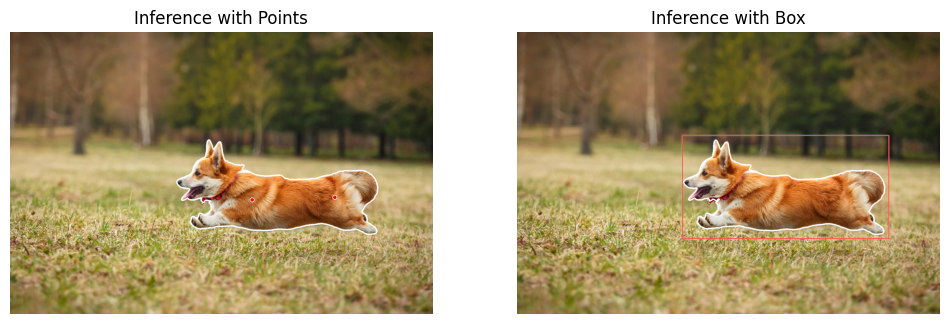

In [3]:
import matplotlib.pyplot as plt
from PIL import Image

# Load images
img_points = Image.open("output_visualization_points.png")
img_box = Image.open("output_visualization_box.png")

# Tạo figure với 2 subplot
plt.figure(figsize=(12, 6))

# Subplot 1: points
plt.subplot(1, 2, 1)
plt.imshow(img_points)
plt.title("Inference with Points")
plt.axis("off")

# Subplot 2: box
plt.subplot(1, 2, 2)
plt.imshow(img_box)
plt.title("Inference with Box")
plt.axis("off")
plt.show()
